# Goal: For all objects in catalog, pull photometry and spectral type from databases. Overplot photometry on a template for that spectral type.

## Imports

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['legend.loc'] = "Upper Right"
plt.rcParams['figure.dpi'] = 900

import scipy.stats as st


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from astropy.io import ascii
from astroplan import (AltitudeConstraint, AirmassConstraint, AtNightConstraint)
from astroplan import FixedTarget, Observer
from astroplan import is_observable, is_always_observable, months_observable
from astroplan import observability_table
from astropy import constants as const
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import *
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astropy.table import Table
from astroquery.simbad import Simbad

import scipy.optimize as optimization
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.neighbors import KernelDensity
from subprocess import *

## Custom Simbad

In [3]:
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype')

## Stars

In [4]:
target_list = ['Vega', 'Sirius', 'HD 168607', 'HD 168625']
backup_list_of_strings = target_list

## Blackbody curve function

## Spectral type CSVs get to temp

In [7]:
main_key = pd.read_csv('mainsequence.csv')
giantsiii_key = pd.read_csv('giantsiii.csv')
supergiantsi_key = pd.read_csv('supergiantsi.csv')

# Setting indexer as spectral type
main_key.set_index('SP_TYPE', inplace=True)
giantsiii_key.set_index('SP_TYPE', inplace=True)
supergiantsi_key.set_index('SP_TYPE', inplace=True)

## Getting Spectral Type

In [8]:
columns = {'MAIN_ID': [0], 'SP_TYPE': [0]}
vis = pd.DataFrame(data = columns)

x = 0
for i in target_list:
    obj = customSimbad.query_object(target_list[x])
    obj.keep_columns(['MAIN_ID', 'SP_TYPE'])
    obj = obj.to_pandas()
    vis = vis.append(obj)
    x = x + 1
    
    
vis = vis.iloc[1:]

vis = vis.values.tolist()

print(vis[3][1])

x = 0
for i in target_list:
    vis[x][0] = vis[x][0].decode("utf-8")
    vis[x][1] = vis[x][1].decode("utf-8")
    x = x + 1
    

vis

b'B6Iap'


[['* alf Lyr', 'A0Va'],
 ['* alf CMa', 'A1V+DA'],
 ['HD 168607', 'B9Iaep'],
 ['HD 168625', 'B6Iap']]

## Getting Temp (k)

In [9]:
x = 0
for i in target_list:
    sp = vis[x][1][0:2]
    temp = main_key.loc[sp][0]
    print(temp)
    vis[x].append(temp)
    x = x + 1
    

vis

9600
9330
11,400
14,300


[['* alf Lyr', 'A0Va', '9600'],
 ['* alf CMa', 'A1V+DA', '9330'],
 ['HD 168607', 'B9Iaep', '11,400'],
 ['HD 168625', 'B6Iap', '14,300']]

### now the list is [name, spectral type, temp]

## Pulling Photometry points

In [10]:
# Courtesy of gist.github.com/mfouesneau, an astrophd dude in Germany

try:  # python 3
    from io import BytesIO
    from http.client import HTTPConnection
except ImportError:  # python 2
    from StringIO import StringIO as BytesIO
    from httplib import HTTPConnection

from astropy.table import Table


def query_sed(pos, radius=5):
    """ Query VizieR Photometry 
    The VizieR photometry tool extracts photometry points around a given position 
    or object name from photometry-enabled catalogs in VizieR.
    
    The VizieR photometry tool is developed by Anne-Camille Simon and Thomas Boch
    .. url:: http://vizier.u-strasbg.fr/vizier/sed/doc/
    
    Parameters
    ----------
    pos: tuple or str
        position tuple or object name
    radius: float
        position matching in arseconds.
    
    Returns
    -------
    table: astropy.Table
        VO table returned by the Vizier service.
        
    >>> query_sed((1.286804, 67.840))
    >>> query_sed("HD1")
    """
    try:
        ra, dec = pos
        target = "{0:f},{1:f}".format(ra, dec)
    except:
        target = pos
    
    url = "http:///viz-bin/sed?-c={target:s}&-c.rs={radius:f}"
    host = "vizier.u-strasbg.fr"
    port = 80
    path = "/viz-bin/sed?-c={target:s}&-c.rs={radius:f}".format(target=target, radius=radius)
    connection = HTTPConnection(host, port)
    connection.request("GET", path)
    response = connection.getresponse()
   
    table = Table.read(BytesIO(response.read()), format="votable")
    return table

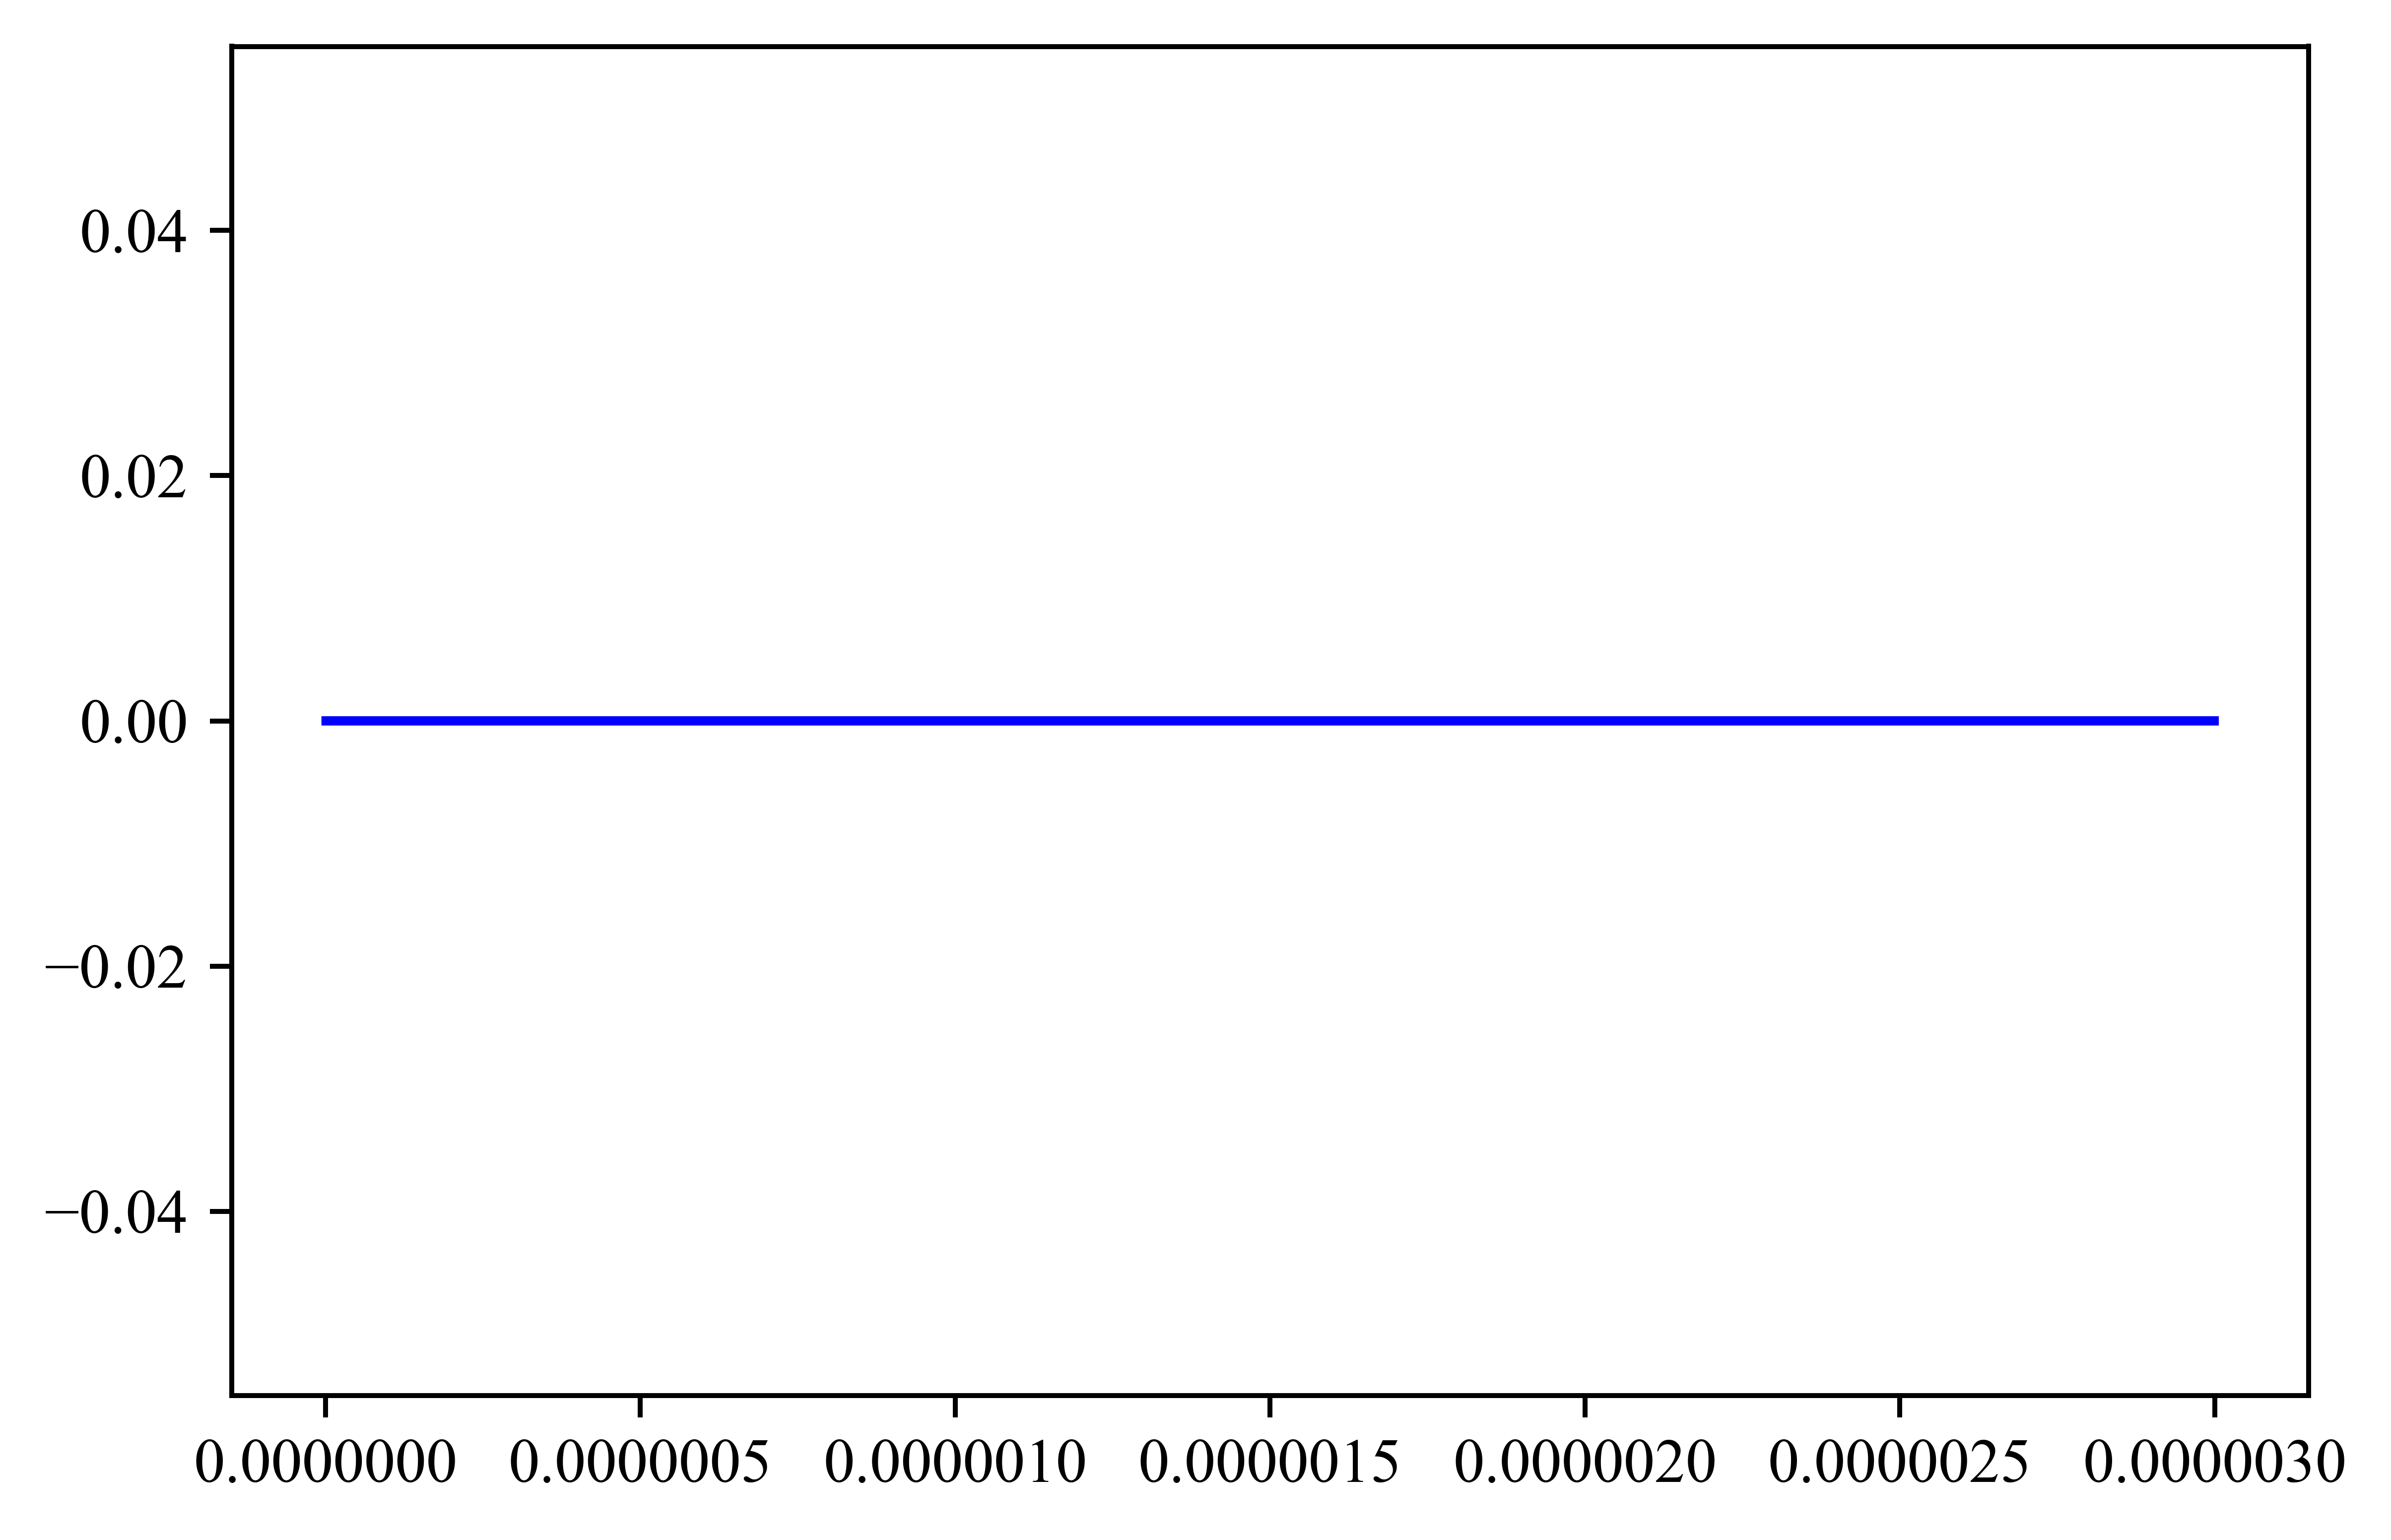

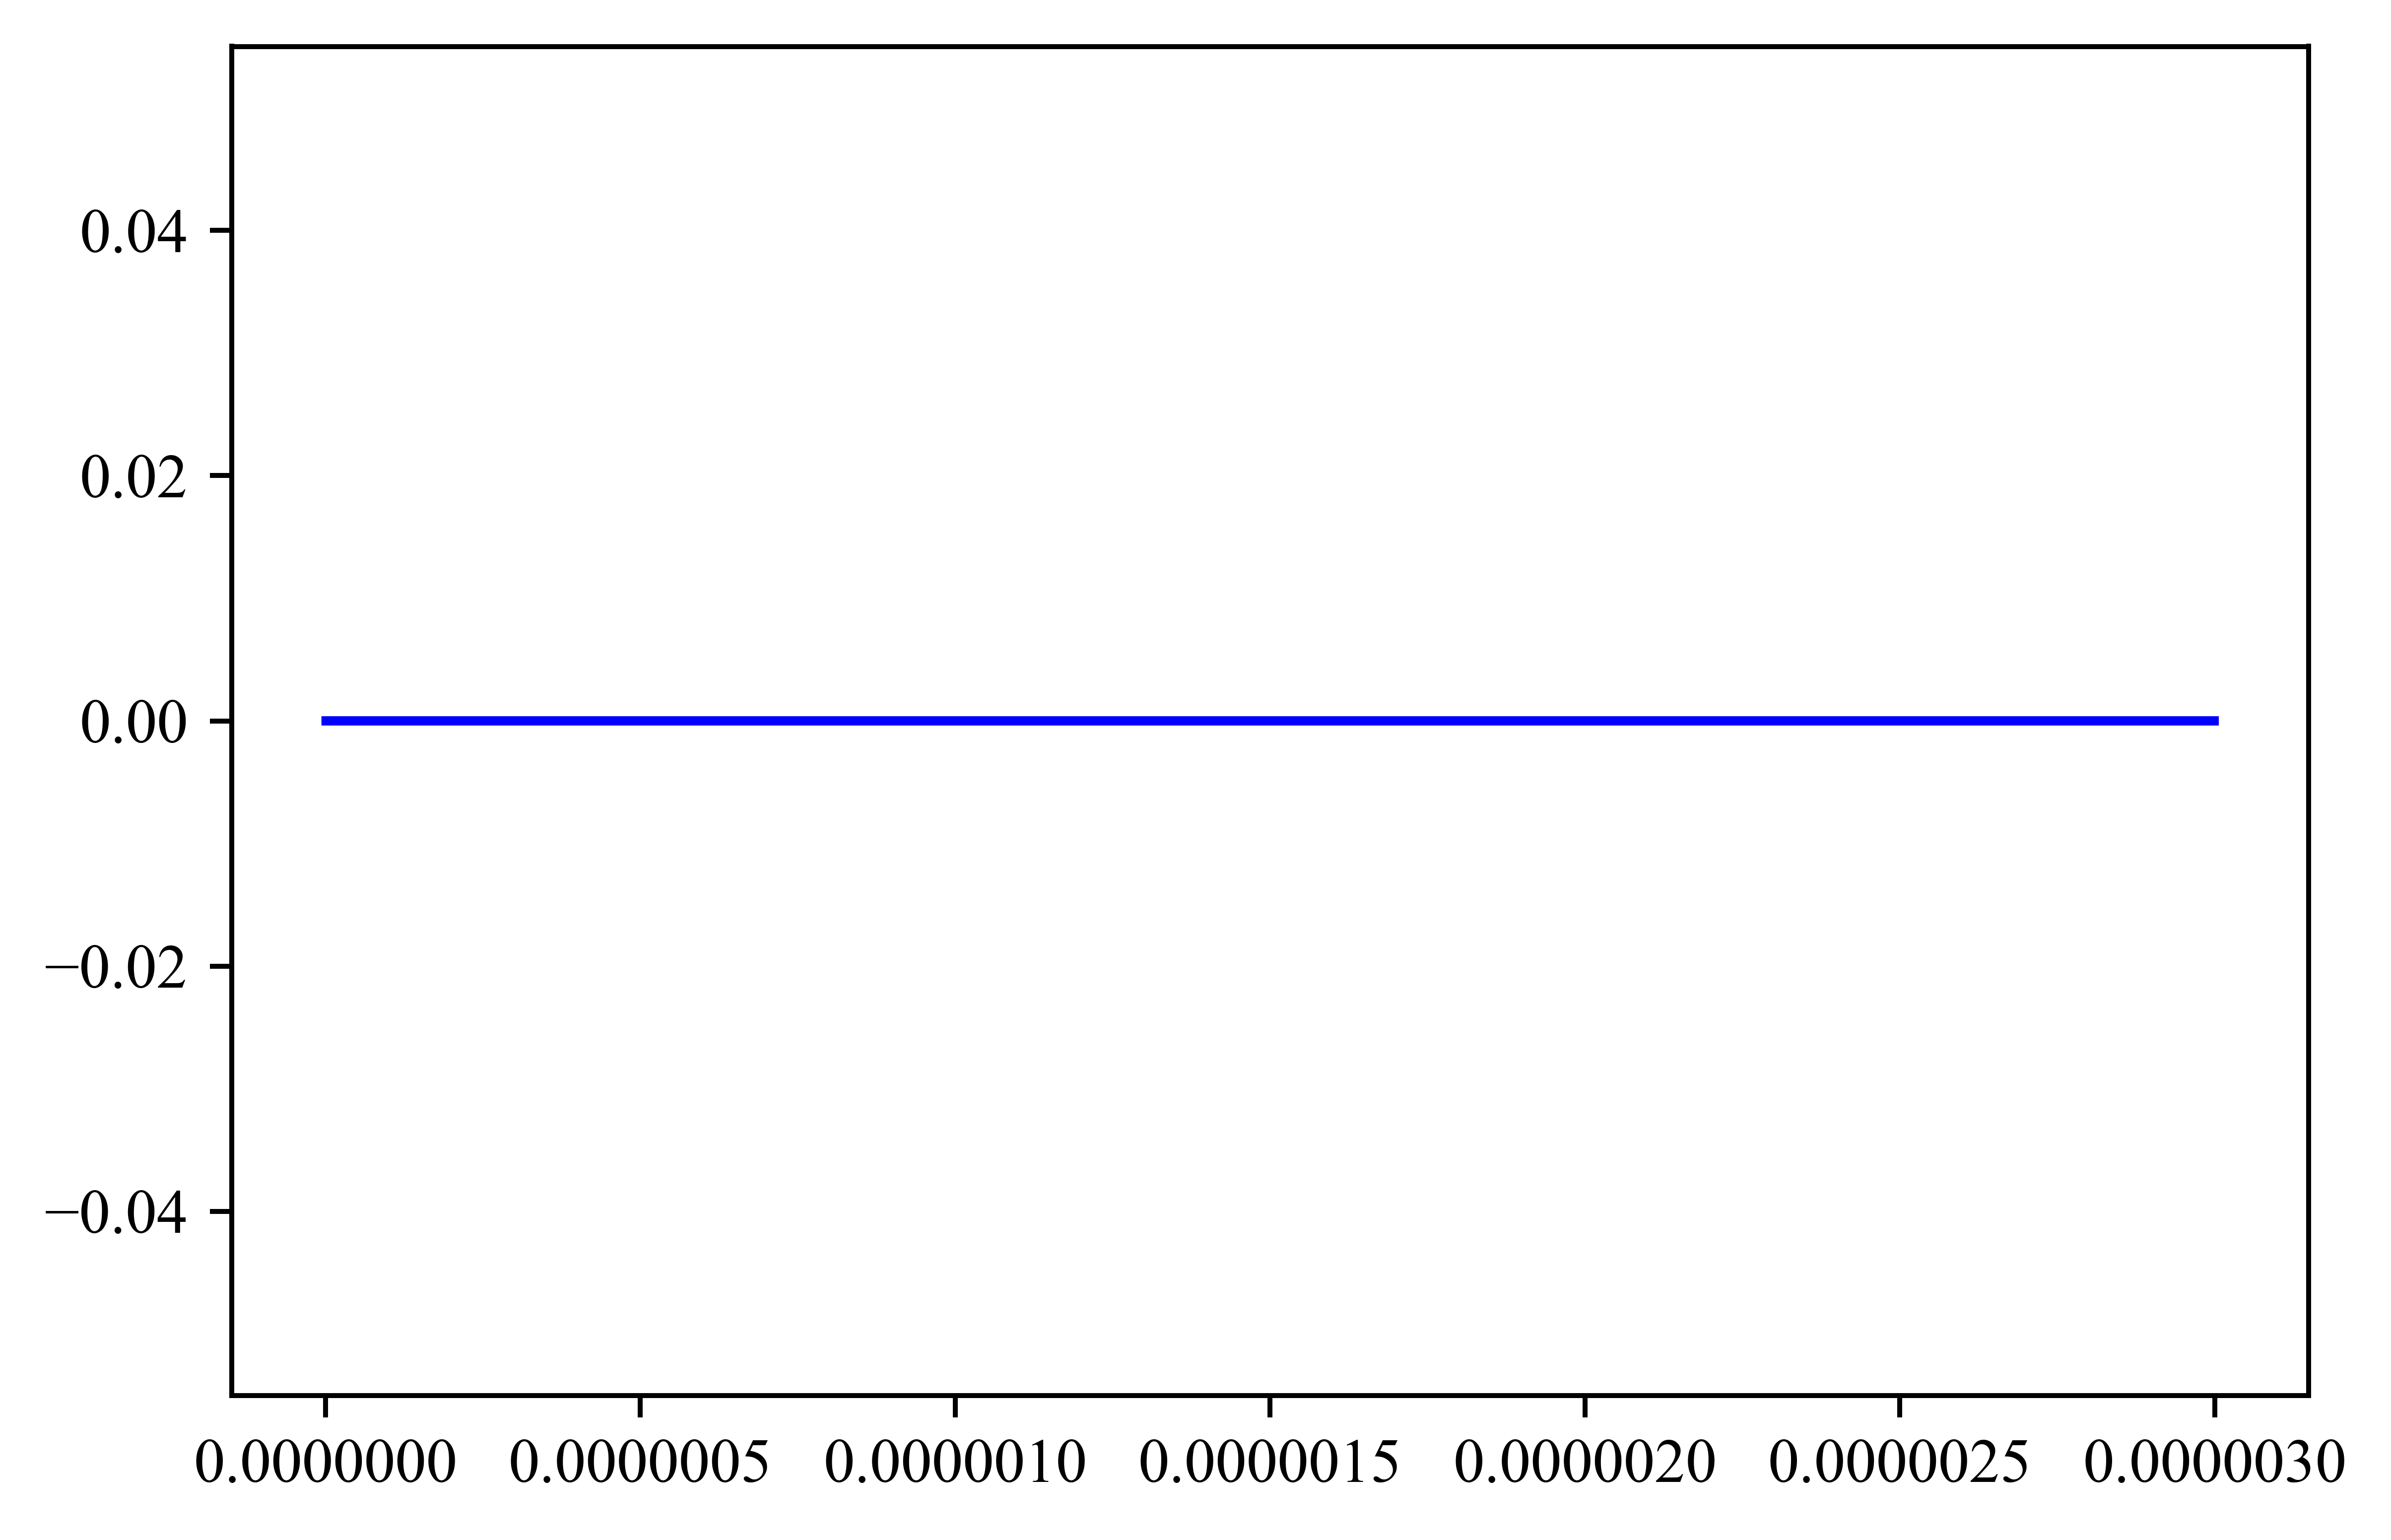

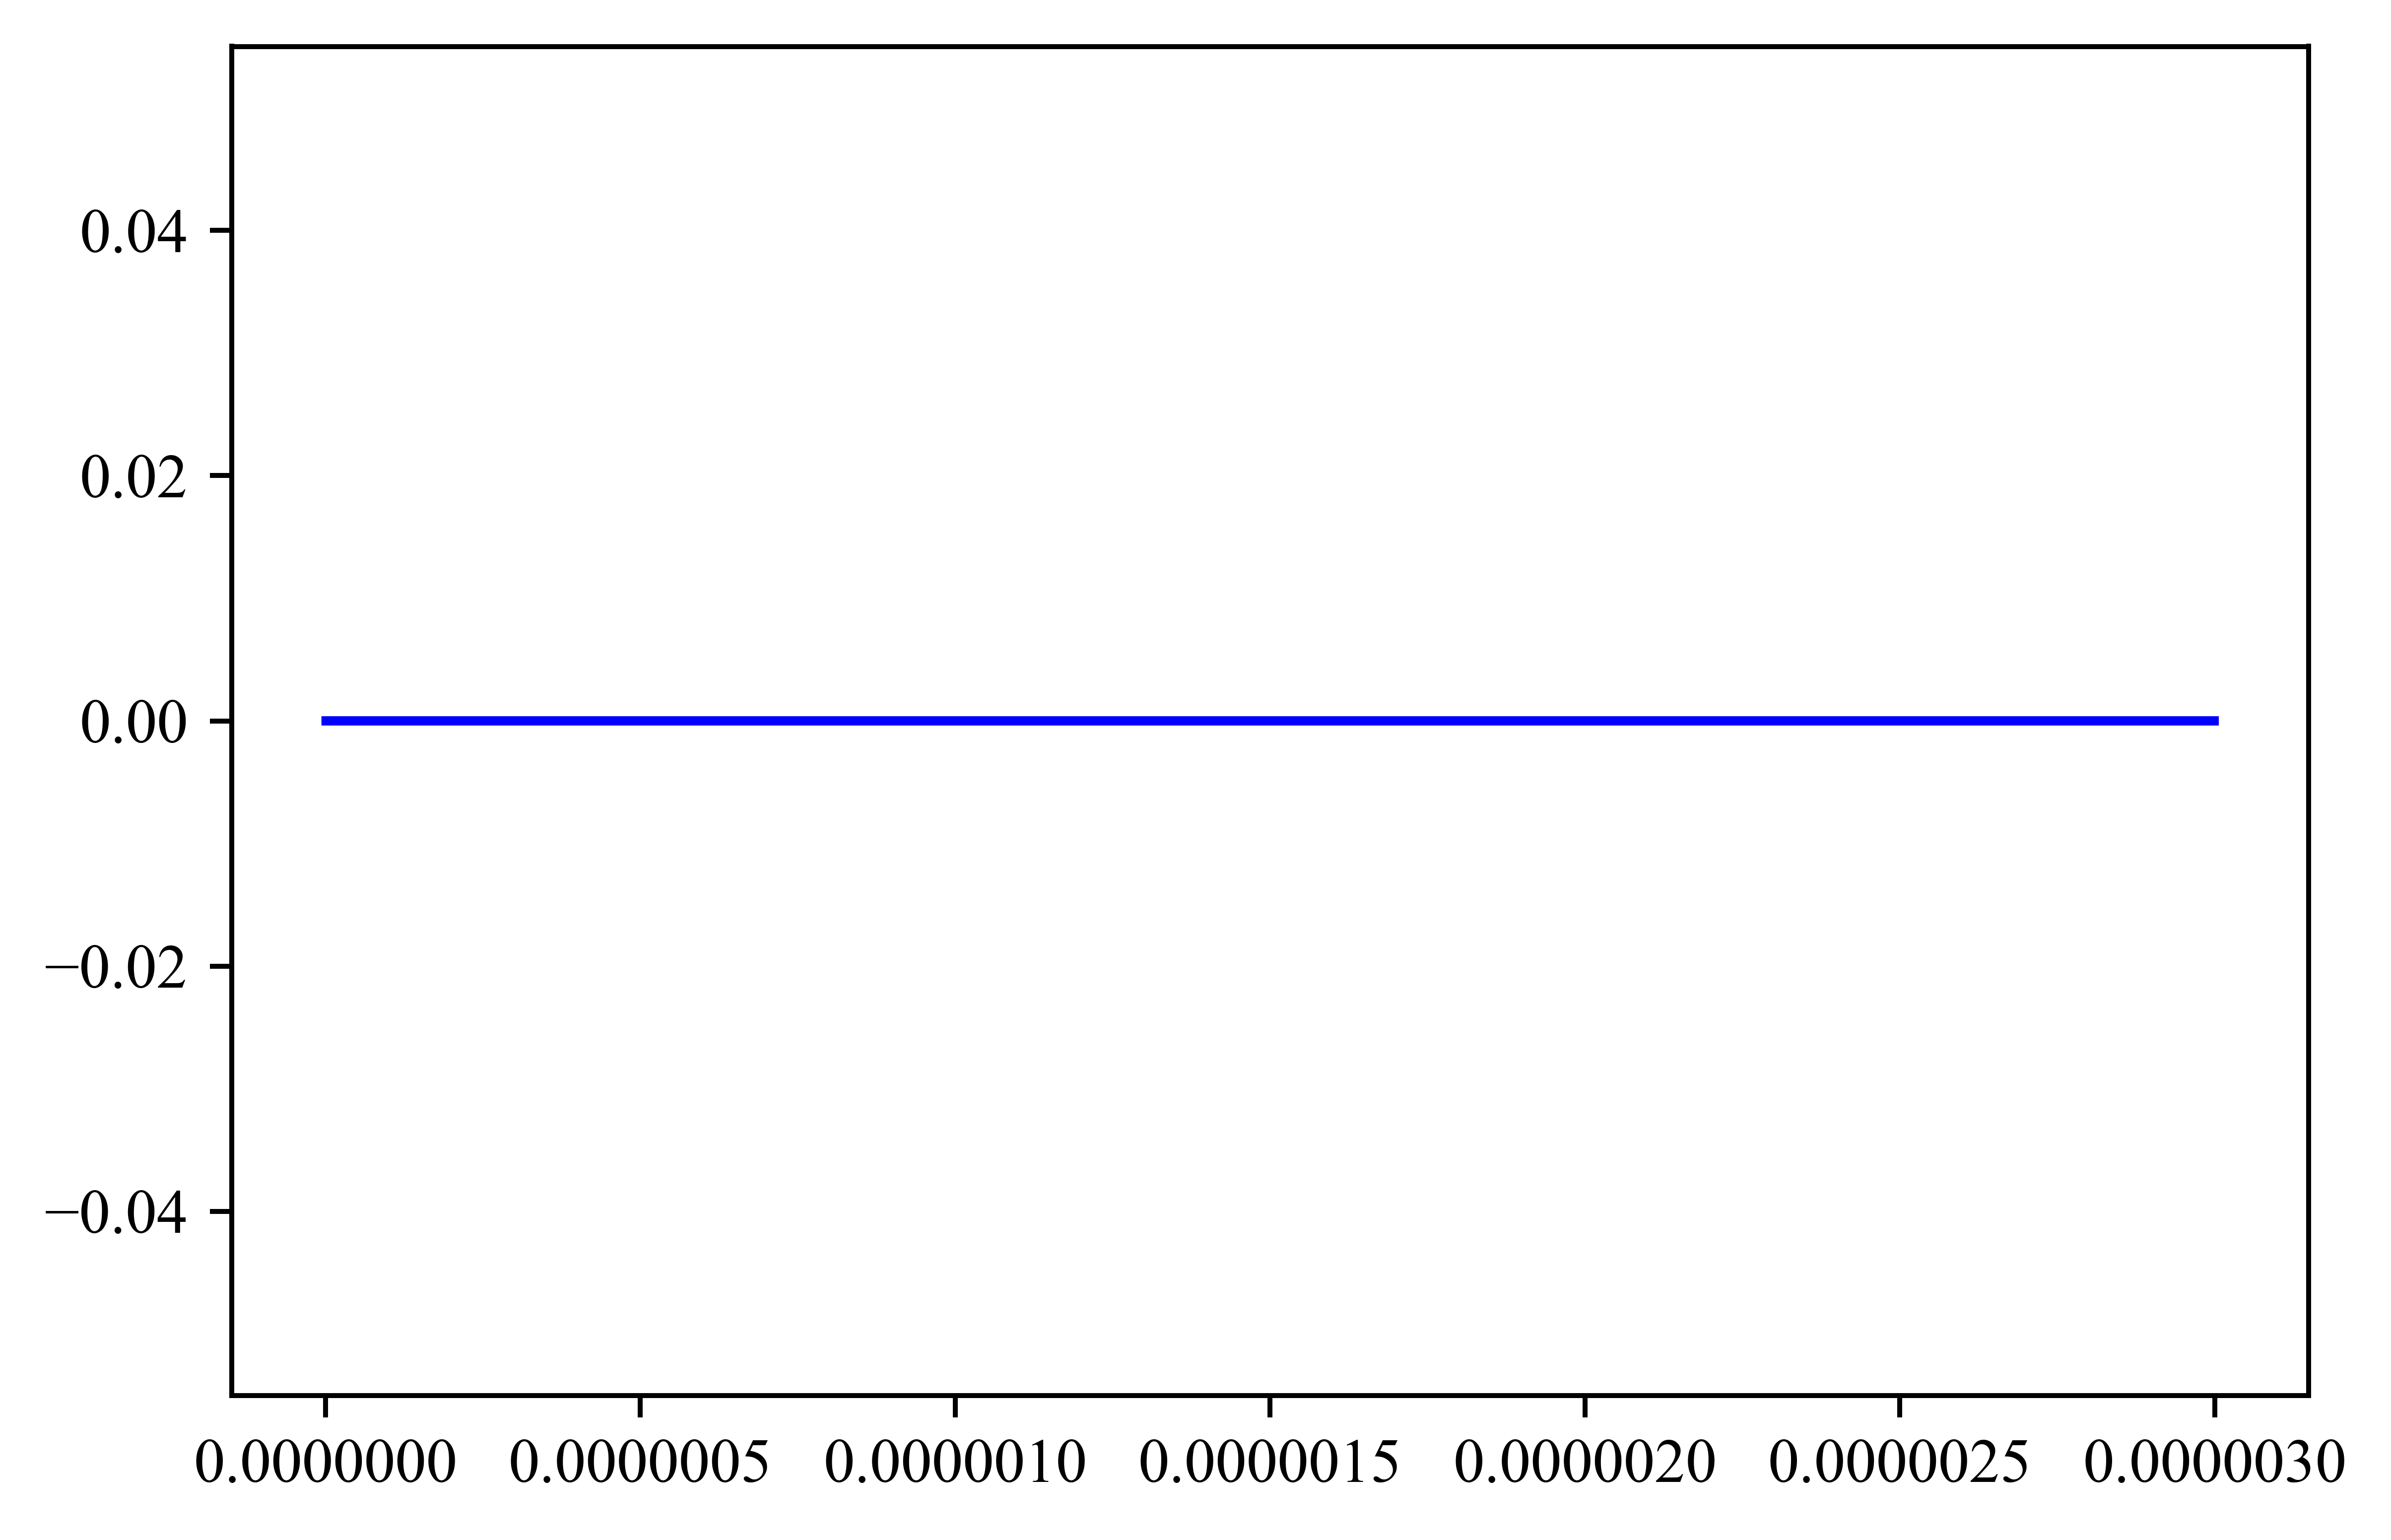

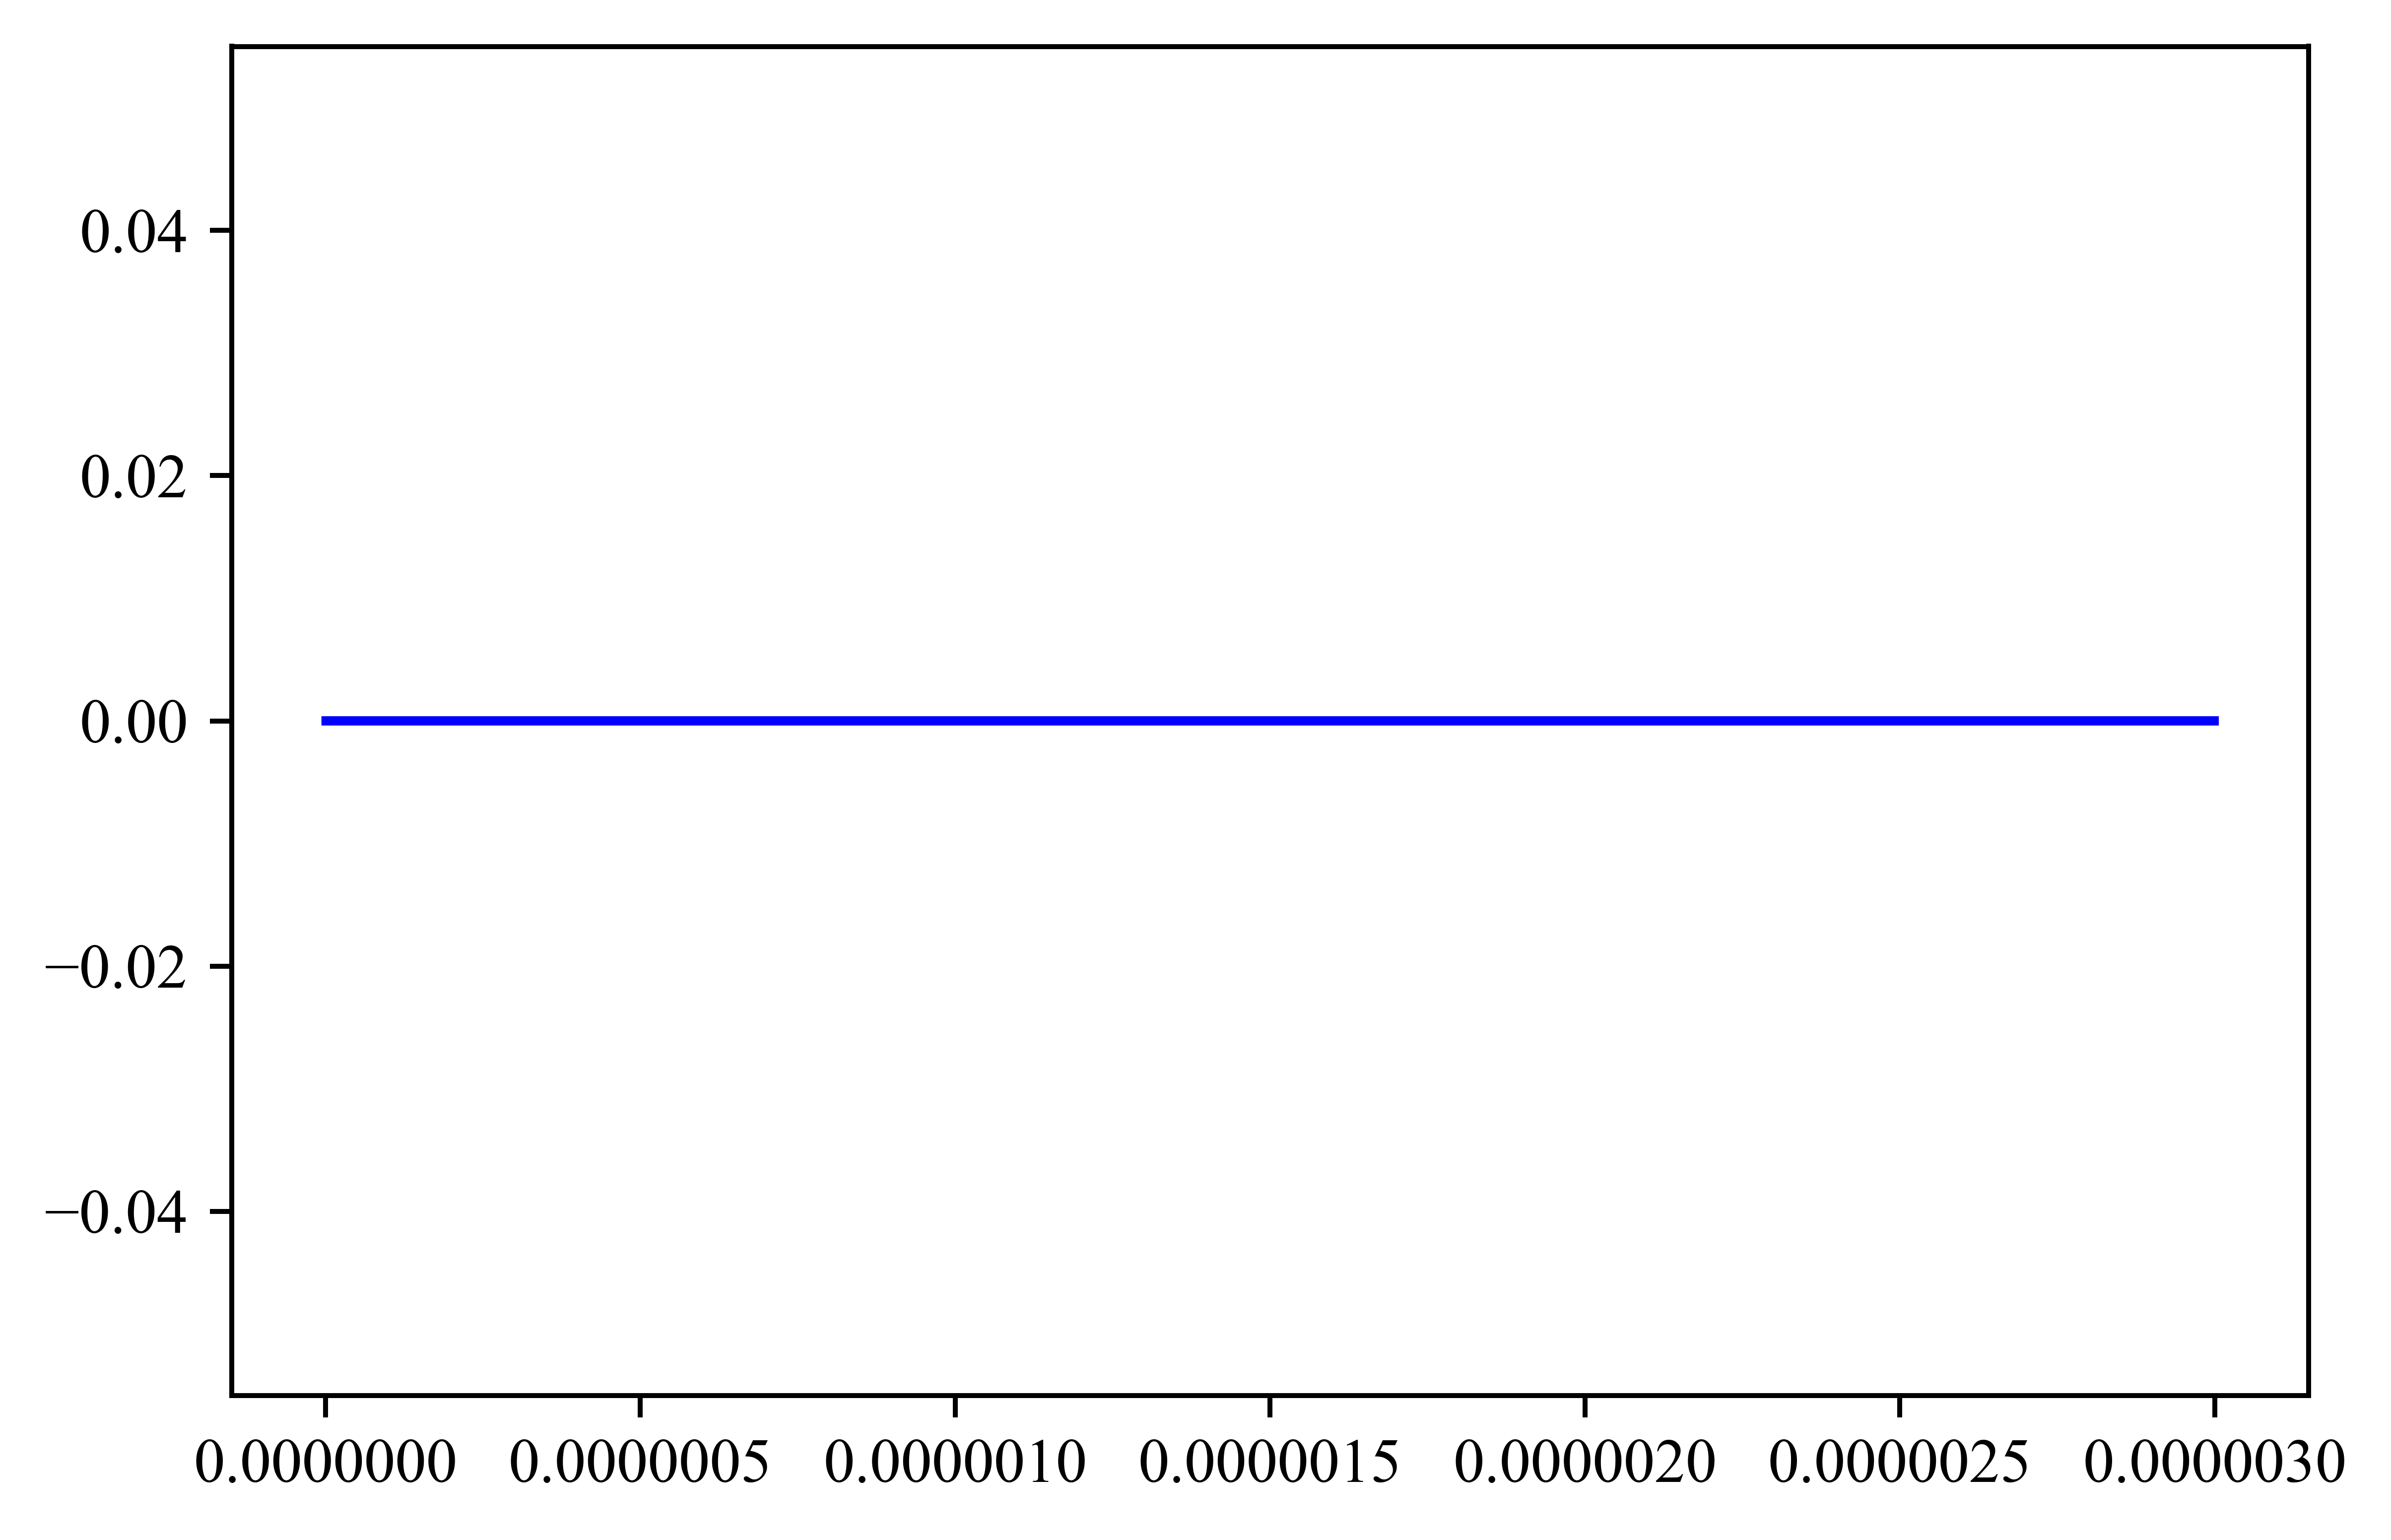

<Figure size 5400x3600 with 0 Axes>

In [40]:
x = 0

for i in target_list:
    
    s = query_sed(vis[x][0].replace(" ", ""))
    del s['_ID'], s['_tabname'], s['_RAJ2000'], s['_DEJ2000']
    s = s.to_pandas()
    #wavelength micrometer = speed of light / frequency in hz
    s['wavelength'] = (299792458/(s['sed_freq']*(1e+9)))*(1e+6)
    #sed_freq sed_flux sed_eflux sed_filter
    #GHz Jy Jy
    #float64 float32 float32 bytes32
    #1 Jy = 10-23 erg s-1 cm-2 Hz-1 = 10-26 Watts m-2 Hz-1 = FsubV
    #print(vis[x])
    #a = plt.scatter(np.log10(s['wavelength']), np.log10(s['sed_flux']), s=5, color = 'r')
    #plt.xlim(-1, 4)
    #plt.xlabel('Wavelength (log(λ/μm))')
    #plt.ylabel('Flux in Janskys')
    
    #labels, locations = plt.xticks()
    #plt.xticks(labels, 10**labels)
    
    vis[x][2] = vis[x][2].replace(',', '')
    
    blackbody = blackbody_lambda(wavelengths, float(vis[x][2]))
    
    #plt.legend(shadow=True, loc='center left', bbox_to_anchor=(1.1, 1))
    #plt.title(backup_list_of_strings[x] + ' Photometry on ' +vis[x][1][0:2] + ' Blackbody')
    #plt.show()
    
    
    wavelengths = np.arange(1e-9, 3e-6, 1e-9) 
    
    plt.plot(wavelengths, blackbody, 'b-')
    plt.show()
    
    
    
    
    
    
    
    #plt.savefig(backup_list_of_strings[x]+'_photometryon'+vis[x][1][0:2]+'_blackbody'+'_.png', bbox_inches='tight', pad_inches=0.25)
    plt.clf()
    plt.rcParams['figure.dpi'] = 900
    
    x = x+1